In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchvision
import torch
import torch.nn.functional as F
import torch.nn as nn
import random
from torch.utils.data import Dataset, random_split, DataLoader
from collections import Counter

In [78]:
trainset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torch.flatten]) # Scales Image values between [0, 255] to [0, 1]
)

testset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torch.flatten]) # Scales Image values between [0, 255] to [0, 1]
)
testset_unflattened =  torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
)

train_dl = DataLoader(trainset, batch_size=64, shuffle=True)
valid_dl = DataLoader(testset, batch_size=64, shuffle=True)

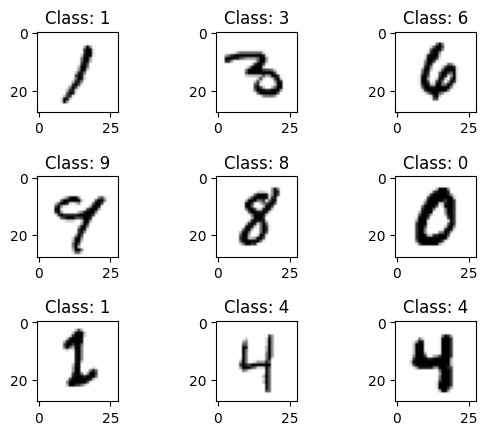

In [48]:
random_sample = [trainset[x] for x in random.sample(range(100), 9)]
fig, axs = plt.subplots(3, 3)
plt.subplots_adjust(wspace=0.3, hspace=0.8)

for idx, (sample, ax) in enumerate(zip(random_sample, axs.flat)):
    ax.imshow(random_sample[idx][0].view(28, 28), cmap='gray_r')
    ax.set_title(f"Class: {random_sample[idx][1]}")

In [49]:
sample_minibatch_features, sample_minibatch_labels = next(iter(train_dl))
print(f"Minibatch size: {sample_minibatch_features.shape}")

Minibatch size: torch.Size([64, 784])


In [50]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28 * 28, 30)  # 5*5 from image dimension
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for _ in range(epochs):
        for i, (inputs, labels) in enumerate(train_dl):
            opt.zero_grad()
            preds = model(inputs)
            loss = loss_func(preds, labels)
            loss.backward()
            opt.step()

In [51]:
import torch.optim as optim
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
num_training_epochs = 10
fit(num_training_epochs, net, criterion, optimizer, train_dl, valid_dl)

In [53]:
def batch_accuracy(preds, targets):
    return (preds.argmax(dim=1) == targets).float().mean()

def validate_epoch(model, val_dl):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in val_dl]
    return round(torch.stack(accs).mean().item(), 4)

with torch.no_grad():
    print(f"Epoch {num_training_epochs+1} validation accuracy: {validate_epoch(net, valid_dl)}", end='\n')

Epoch 11 validation accuracy: 0.9581


In [56]:
xb, yb = next(iter(valid_dl))  # xb: [batch, 1, 28, 28], yb: [batch]

# vyberieme prvú vzorku v batchi
x_single = xb[0:1]  # tvar [1, 1, 28, 28] -> zachová batch dimenziu
y_true = yb[0]

with torch.no_grad():  # vypne gradienty, rýchlejšie a menej pamäte
    pred = net(x_single)  # tvar: [1, 10] pre klasifikáciu MNIST
    pred_label = pred.argmax(dim=1)  # najpravdepodobnejšia trieda

In [57]:
print(f"Skutočná hodnota: {y_true.item()}")
print(f"Predikovaná hodnota: {pred_label.item()}")

Skutočná hodnota: 1
Predikovaná hodnota: 1


In [76]:
def show_mnist_image(testset, idx):
    """
    Vykreslí obrázok z MNIST testsetu podľa zadaného indexu.

    Parametre:
    - testset: dataset MNIST (torchvision.datasets.MNIST)
    - idx: index obrázka, ktorý chceme zobraziť
    """
    image, label = testset[idx]           # vezme vzorku
    image = image.squeeze().numpy()       # [1,28,28] -> [28,28] pre matplotlib

    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

Index 6053
Prediction: 3 | Label: 5


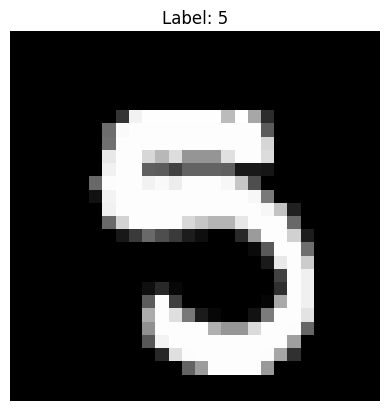

In [85]:
idx = random.randint(0, len(testset))
digit = testset.__getitem__(idx)[0]
label = testset.__getitem__(idx)[1]
with torch.no_grad():  # vypne gradienty, rýchlejšie a menej pamäte
    pred = net(digit)  # tvar: [1, 10] pre klasifikáciu MNIST
    print('Index', idx)
    print(f'Prediction: {pred.argmax()} | Label: {label}')
    show_mnist_image(testset_unflattened, idx)

In [87]:
torch.save(net.state_dict(), "mnist_model_weights.pth")